# Import Libraries

In [1]:
import pandas as pd
import numpy as np

# Read Hydro Energy Production Dataset

In [178]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_production_dataset.csv')

data.head()

,Country,Date,Value,Precipitation
0,Australia,2023-03-01,1215.8041,0.080641
1,Australia,2023-02-01,942.5558,0.127869
2,Australia,2023-01-01,1190.7296,0.159242
3,Australia,2022-12-01,1110.1523,0.105662
4,Australia,2022-11-01,1397.5839,0.073524


## Extract Data for each country

In [179]:
countries = data['Country'].unique()

hydro_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'Hydro' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Precipitation']
    ]
    
    # Store the filtered data in the dictionary
    hydro_production_data[country] = country_energy_production.reset_index(drop=True)

hydro_production_data['United States']

,Date,Value,Precipitation
0,2023-03-01,21249.7243,0.105574
1,2023-02-01,19956.5880,0.089348
2,2023-01-01,23501.7484,0.109538
3,2022-12-01,22536.6848,0.103125
4,2022-11-01,19468.4630,0.098546
...,...,...,...
154,2010-05-01,27562.7260,0.103642
155,2010-04-01,20358.4720,0.091130
156,2010-03-01,22395.3570,0.089837
157,2010-02-01,22473.8710,0.084075


# Model Building

In [4]:
import matplotlib.pyplot as plt

# United States Hydro Energy Generation

In [5]:
data = hydro_production_data['United States']

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

print(data.head())
print(data.shape)

                Value  Precipitation
Date                                
2010-01-01  24283.860       0.090444
2010-02-01  22473.871       0.084075
2010-03-01  22395.357       0.089837
2010-04-01  20358.472       0.091130
2010-05-01  27562.726       0.103642
(159, 2)


### Split train and test data

In [6]:
# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                Value  Precipitation
Date                                
2010-01-01  24283.860       0.090444
2010-02-01  22473.871       0.084075
2010-03-01  22395.357       0.089837
2010-04-01  20358.472       0.091130
2010-05-01  27562.726       0.103642
(133, 2)

                 Value  Precipitation
Date                                 
2021-01-01  26385.1678       0.086840
2021-02-01  22549.3400       0.089872
2021-03-01  21644.5928       0.095176
2021-04-01  19576.9069       0.082930
2021-05-01  23857.1409       0.106700
(27, 2)


## Univariate Model - ARIMA - Monthly

In [7]:
from statsmodels.tsa.arima.model import ARIMA

The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,0,0)(2,1,0)[12] 

Figure below show the result from R:
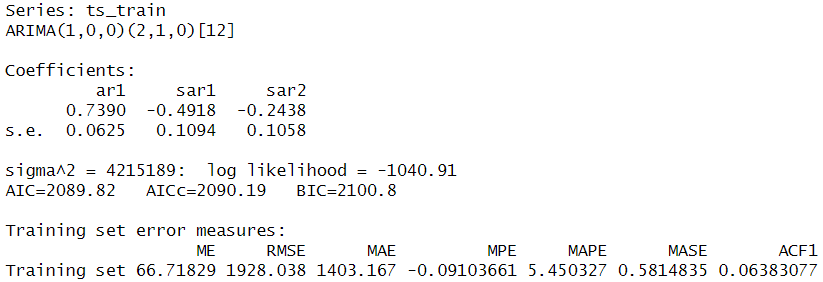

In [8]:
# Create the ARIMA model with the specified order
us_monthly_arima = ARIMA(train['Value'].values, order=(1,0,0), seasonal_order=(2,1,0,12))
# Fit the model to the training data
us_monthly_arima = us_monthly_arima.fit()
print(us_monthly_arima.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  133
Model:             ARIMA(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -1108.175
Date:                          Tue, 25 Jul 2023   AIC                           2224.350
Time:                                  00:03:51   BIC                           2235.533
Sample:                                       0   HQIC                          2228.891
                                          - 133                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5241      0.046     11.369      0.000       0.434       0.614
ar.S.L12      -0.0276      0.059     -0.468      0.

In [9]:
# Generate predictions
predictions = us_monthly_arima.predict(start=len(train), end=len(train) + len(test) - 1)

# Evaluate the model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

print("Mean Absolute Error: ", mean_absolute_error(predictions, test['Value'].values))
mse = mean_squared_error(predictions, test['Value'].values)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  3529.1012145124464
Mean Squared Error:  21845654.069960624
Root Mean Squared Error:  4673.933468713544


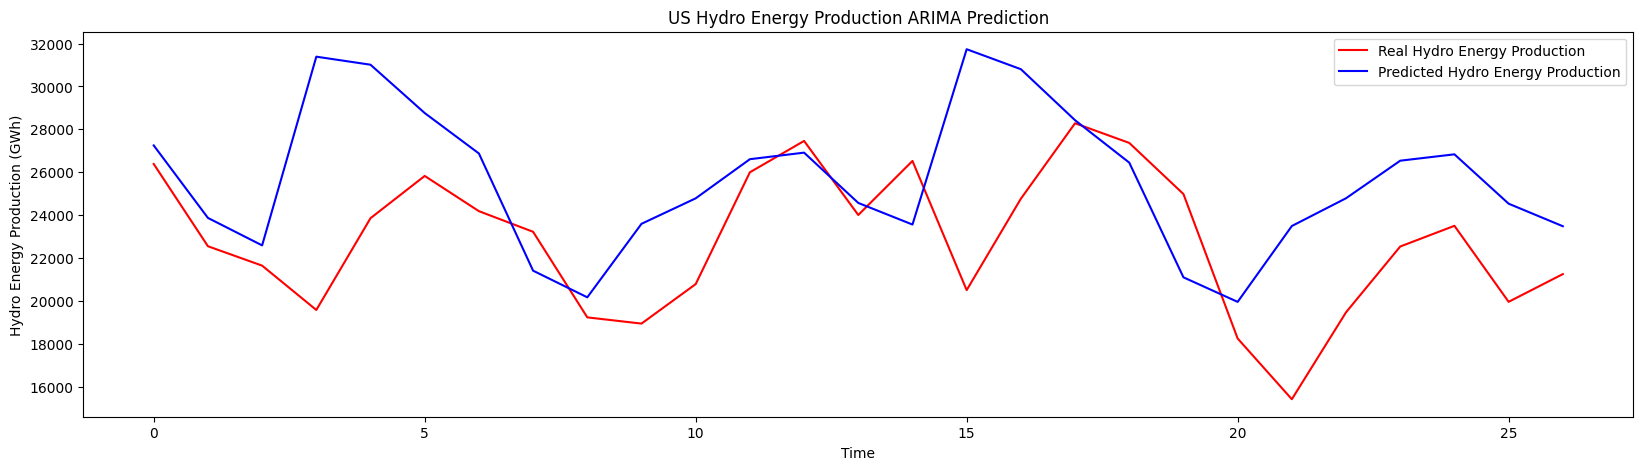

In [10]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## SVR - Univariate

In [11]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [12]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 12  # Define the number of previous time steps to consider

# Creating a data structure with 12 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(121, 12) (121,)


In [13]:
# Build and Train the SVM Model
us_monthly_svr_model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05) # Specify desired hyperparameters
us_monthly_svr_model.fit(x_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [14]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Hydro Energy Production
y_pred = us_monthly_svr_model.predict(x_test).reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)
print(y_pred.shape)

(27, 1)


In [15]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  2546.612090898266
Mean Squared Error:  10793149.75747161
Root Mean Squared Error:  3285.292948501185


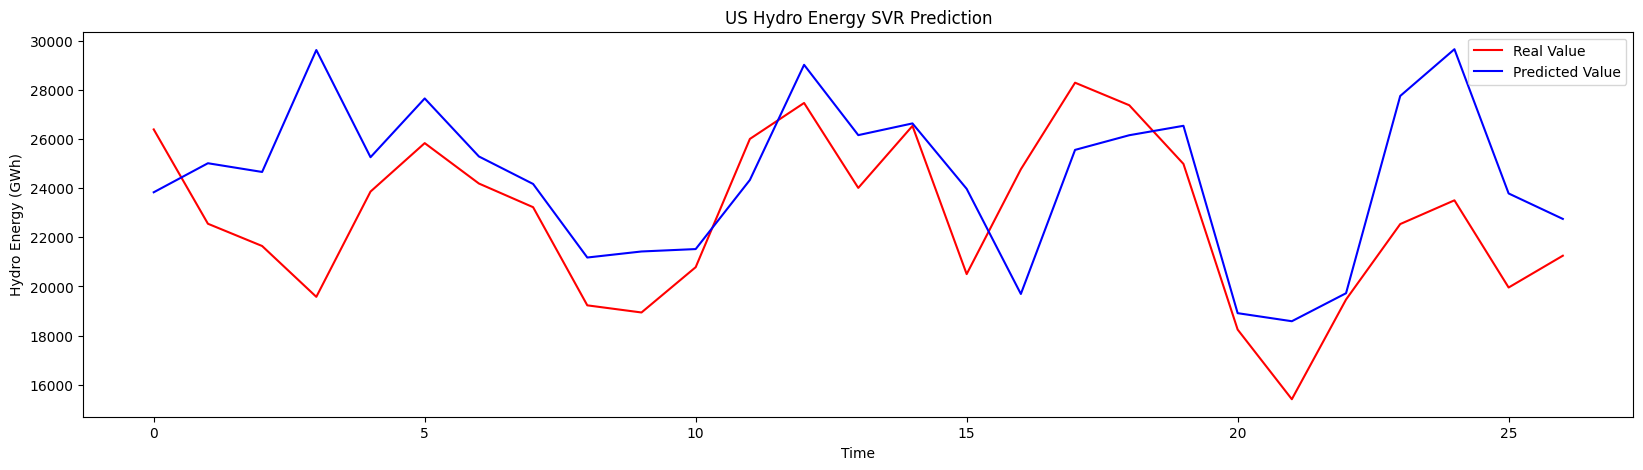

In [16]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(y_pred, color='blue', label='Predicted Value')
plt.title('US Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Monthly

In [17]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [18]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 12

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the model
us_monthly_ann = Sequential()
us_monthly_ann.add(Dense(64, activation='sigmoid', input_shape=(12,)))
us_monthly_ann.add(Dense(1, activation='sigmoid'))

us_monthly_ann.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
us_monthly_ann.fit(X_train, y_train, epochs=25, batch_size=1)

Epoch 1/25
121/121 [==============================] - 1s 2ms/step - loss: 0.0626
Epoch 2/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0525
Epoch 3/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0469
Epoch 4/25
121/121 [==============================] - 0s 983us/step - loss: 0.0408
Epoch 5/25
121/121 [==============================] - 0s 962us/step - loss: 0.0362
Epoch 6/25
121/121 [==============================] - 0s 978us/step - loss: 0.0340
Epoch 7/25
121/121 [==============================] - 0s 945us/step - loss: 0.0316
Epoch 8/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 9/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 10/25
121/121 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 11/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0260
Epoch 12/25
121/121 [==============================] - 0s 1ms/step - loss: 0.0264
Epoch 13/25
121/1

In [21]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-12:i, 0])
X_test = np.array(X_test)

predicted_value = us_monthly_ann.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)

1/1 [==============================] - 0s 218ms/step


In [22]:
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, test['Value'].values))
mse = mean_squared_error(predicted_value, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  2462.1453346064814
Mean Squared Error:  9091411.574205808
Root Mean Squared Error:  3015.196772054157


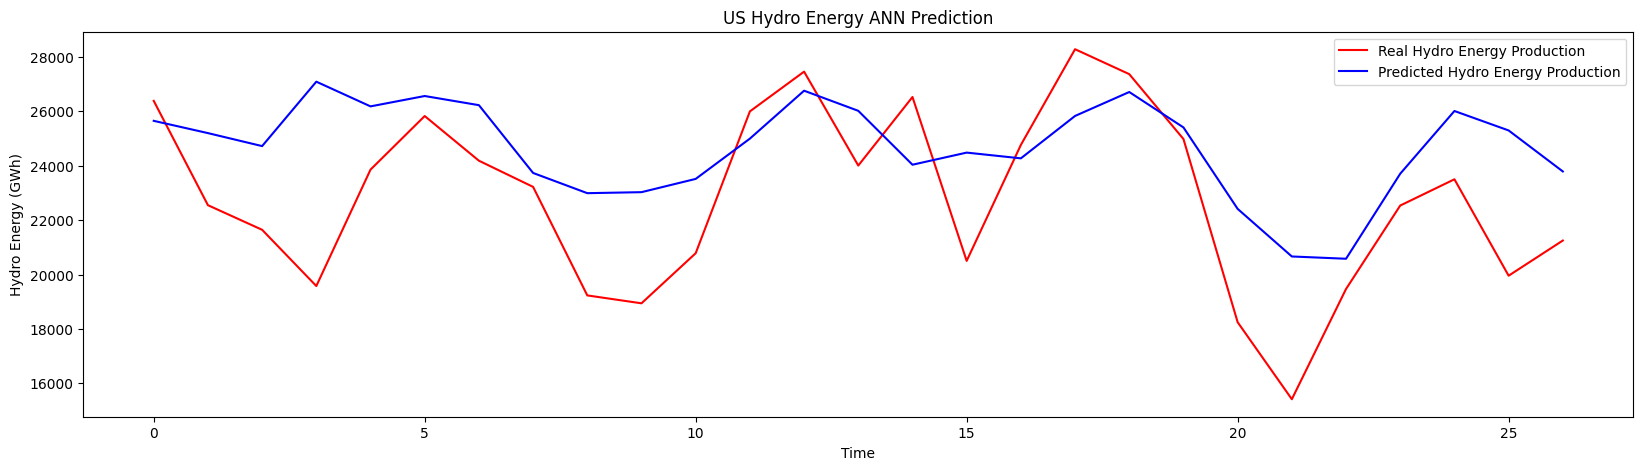

In [23]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predicted_value, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Monthly

In [24]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)
print(training_set_scaled.shape)

(133, 1)


In [25]:
# Creating a data structure with 12 timestamps and 1 output
X_train = []
y_train = []
for i in range(12, len(train)):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [26]:
print(X_train.shape)
print(y_train.shape)

(121, 12)
(121,)


In [27]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [28]:
# Building the RNN(LSTM)

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [29]:
# Initialising the RNN
us_monthly_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
us_monthly_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))

us_monthly_uni_lstm.add(LSTM(units = 64, return_sequences = True))

us_monthly_uni_lstm.add(LSTM(units = 64))

# Adding the output layer
us_monthly_uni_lstm.add(Dense(units = 1))

In [30]:
# Compiling the RNN
us_monthly_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
us_monthly_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
4/4 [==============================] - 7s 12ms/step - loss: 0.2125
Epoch 2/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0802
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0991
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0688
Epoch 5/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0786
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0769
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0650
Epoch 8/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0679
Epoch 9/100
4/4 [==============================] - 0s 19ms/step - loss: 0.0667
Epoch 10/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0629
Epoch 11/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0639
Epoch 12/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0638
Epoch 13/100
4/4 [==============================]

In [31]:

dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 12:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(12, len(test)+12):
    X_test.append(inputs[i-12:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_value = us_monthly_uni_lstm.predict(X_test)
predicted_value = sc.inverse_transform(predicted_value)

1/1 [==============================] - 2s 2s/step


In [32]:
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, test['Value'].values))
mse = mean_squared_error(predicted_value, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  2905.3104303240743
Mean Squared Error:  11804080.929610072
Root Mean Squared Error:  3435.7067583846665


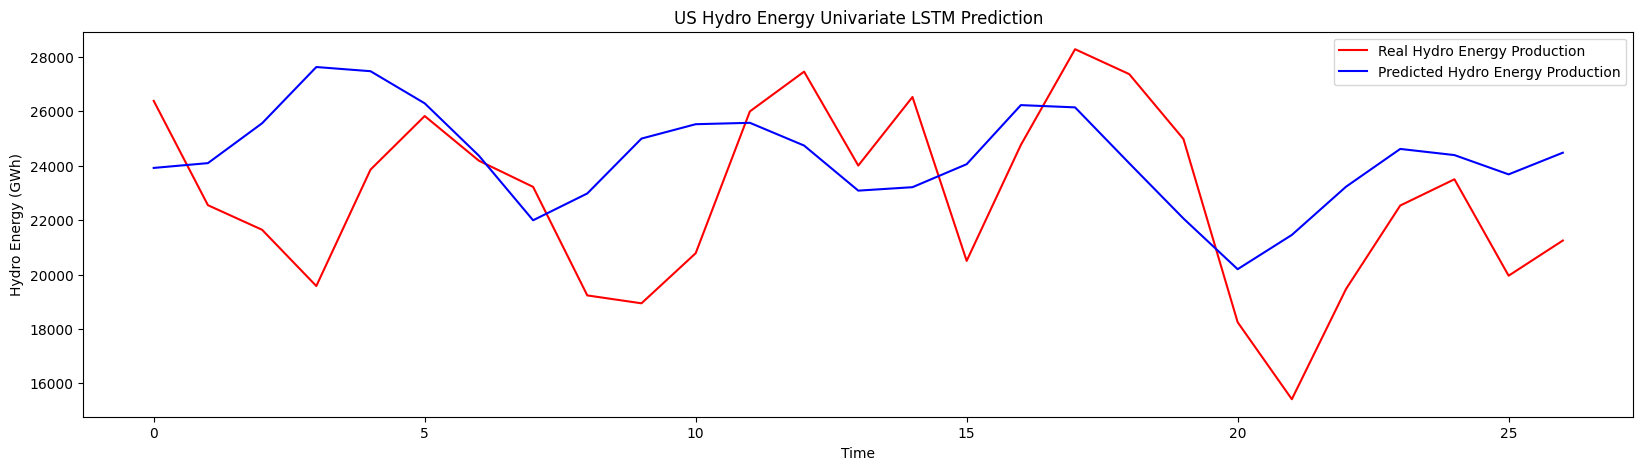

In [33]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predicted_value, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [34]:
data = hydro_production_data['United States']

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date').sort_index()

data.shape

(159, 2)

In [35]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2010-01-01,0.090444,24283.860
2010-02-01,0.084075,22473.871
2010-03-01,0.089837,22395.357
2010-04-01,0.091130,20358.472
2010-05-01,0.103642,27562.726


In [36]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(133, 2)
(27, 2)

(133, 1)
(27, 1)


In [37]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)


In [38]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 12  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 60 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

(121, 12, 2)


In [39]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

us_monthly_multi_lstm = Sequential()
us_monthly_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
us_monthly_multi_lstm.add(LSTM(units = 64, return_sequences = True))
us_monthly_multi_lstm.add(LSTM(units = 64))
us_monthly_multi_lstm.add(Dense(1))

us_monthly_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
us_monthly_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
4/4 [==============================] - 6s 19ms/step - loss: 0.1960
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0791
Epoch 3/100
4/4 [==============================] - 0s 17ms/step - loss: 0.0806
Epoch 4/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0670
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0725
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0652
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0646
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0648
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0619
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0616
Epoch 11/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0619
Epoch 12/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0609
Epoch 13/100
4/4 [==============================]

In [41]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 12:]
inputs = X_scaler.transform(inputs)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))
predicted_value = us_monthly_multi_lstm.predict(X_test1)
predicted_value = y_scaler.inverse_transform(predicted_value)
real_value = y_scaler.inverse_transform(y_test)

1/1 [==============================] - 1s 1s/step


In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(predicted_value, real_value))
mse = mean_squared_error(predicted_value, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3121.376078240741
Mean Squared Error:  12362425.53044779
Root Mean Squared Error:  3516.0241083428014


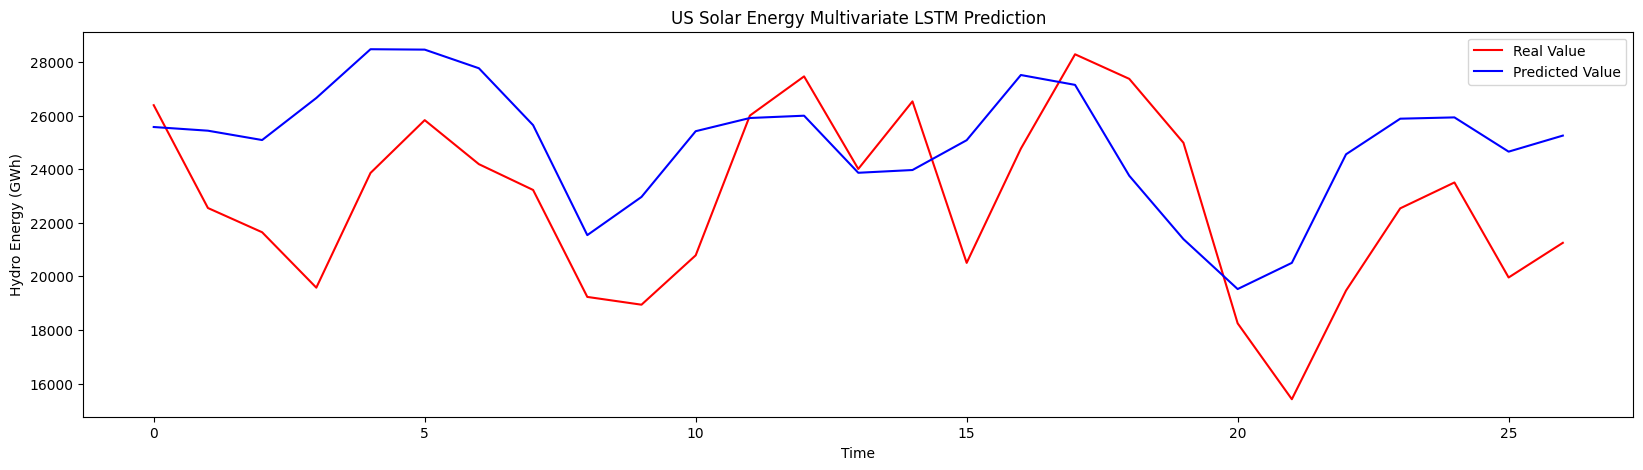

In [43]:
# Visualising the results
plt.figure(figsize=(20,5))
# plt.plot(hist_value, color = 'green', label = 'Historical Value')
# plt.plot(range(len(hist_value), len(hist_value) + len(real_value)), real_value, color='red', label='Real Value')
# plt.plot(range(len(hist_value), len(hist_value) + len(predicted_value)), predicted_value, color='blue', label='Predicted Value')
plt.plot(real_value, color='red', label='Real Value')
plt.plot(predicted_value, color='blue', label='Predicted Value')
plt.title('US Solar Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Resample to daily data

In [180]:
# hypro_production_data
for country_data in hydro_production_data:
    
    # set time as the index
    hydro_production_data[country_data]['Date'] = pd.to_datetime(hydro_production_data[country_data]['Date'])
    hydro_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    hydro_production_data[country_data]['Value'] = (hydro_production_data[country_data]['Value']/
                                                    hydro_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = hydro_production_data[country_data].resample('D').interpolate('linear')
    hydro_production_data[country_data] = daily_data
    
hydro_production_data['United States']

,Value,Precipitation
Date,,
2010-01-01,783.350323,0.090444
2010-01-02,783.972514,0.090238
2010-01-03,784.594705,0.090033
2010-01-04,785.216896,0.089827
2010-01-05,785.839087,0.089622
...,...,...
2023-02-25,689.369307,0.103256
2023-02-26,688.395725,0.103836
2023-02-27,687.422142,0.104415


In [181]:
hydro_daily_production_data = {}

for country in hydro_production_data:
    hydro_daily_production_data[country] = hydro_production_data[country].copy()
    hydro_daily_production_data[country] = hydro_daily_production_data[country].reset_index()
    hydro_daily_production_data[country]['Country'] = country
    hydro_daily_production_data[country] = hydro_daily_production_data[country][['Country'] + list(hydro_daily_production_data[country].columns[:-1])]
    
# Concatenate the datasets into a single DataFrame
hydro_dataset = pd.concat(hydro_daily_production_data.values())
# Reset the index of the concatenated DataFrame
hydro_dataset.reset_index(drop=True, inplace=True)

# Save the concatenated DataFrame to a CSV file
hydro_dataset.to_csv('F:\APU\FYP\Dataset\Cleaned_data\hydro_daily_production_dataset.csv', index=False)

# Model Building

### Split train and test data

In [45]:
data = hydro_production_data['United States']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                 Value
Date                  
2010-01-01  783.350323
2010-01-02  783.972514
2010-01-03  784.594705
2010-01-04  785.216896
2010-01-05  785.839087
(4019, 1)

                 Value
Date                  
2021-01-01  851.134445
2021-01-02  849.656998
2021-01-03  848.179550
2021-01-04  846.702103
2021-01-05  845.224655
(790, 1)


## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (1,1,1)(0,1,0)[365] 

#### Figure below show the result from R:

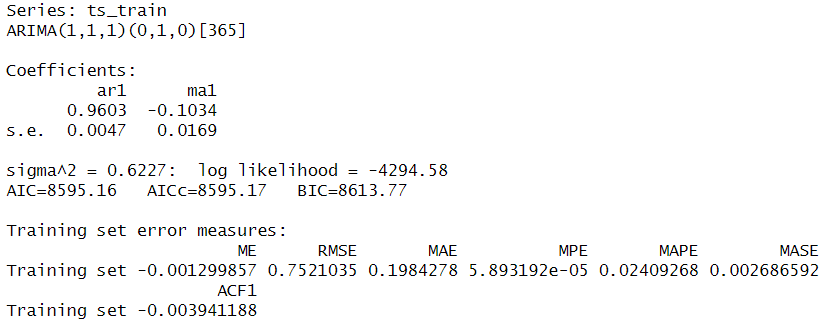

In [154]:
# Create the ARIMA model with the specified order
us_daily_ARIMA = ARIMA(train.values, order=(1,1,1), seasonal_order=(0,1,0,365))
# Fit the model to the training data
us_daily_ARIMA = us_daily_ARIMA.fit()
print(us_daily_ARIMA.summary())

MemoryError: Unable to allocate 4.06 GiB for an array with shape (368, 368, 4020) and data type float64

In [174]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
us_hydro_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\us_hydro_arima_model.rds")

In [175]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(us_hydro_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test.values))
mse = mean_squared_error(predictions.rx('mean')[0], test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  125.85035719335252
Mean Squared Error:  20092.772599532196
Root Mean Squared Error:  141.74897741970557


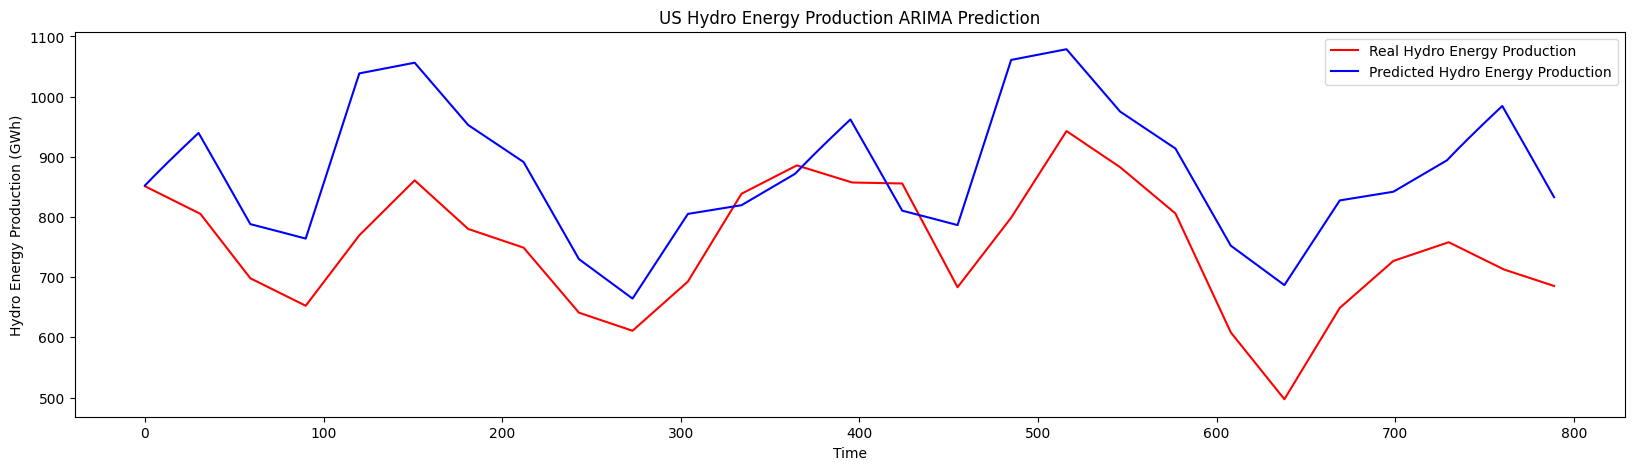

In [176]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy Production ARIMA Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy Production (GWh)')
plt.legend()
plt.show()

## Univariate - SVR - Daily

In [50]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [93]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(3654, 365) (3654,)


In [98]:
# Build and Train the SVM Model
us_daily_svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
us_daily_svr.fit(x_train, y_train)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [121]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Solar Energy Production
svr_y_pred = us_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(y_pred.shape)

(790, 1)


In [122]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  95.89629096445258
Mean Squared Error:  14379.970186720095
Root Mean Squared Error:  119.91651340295087


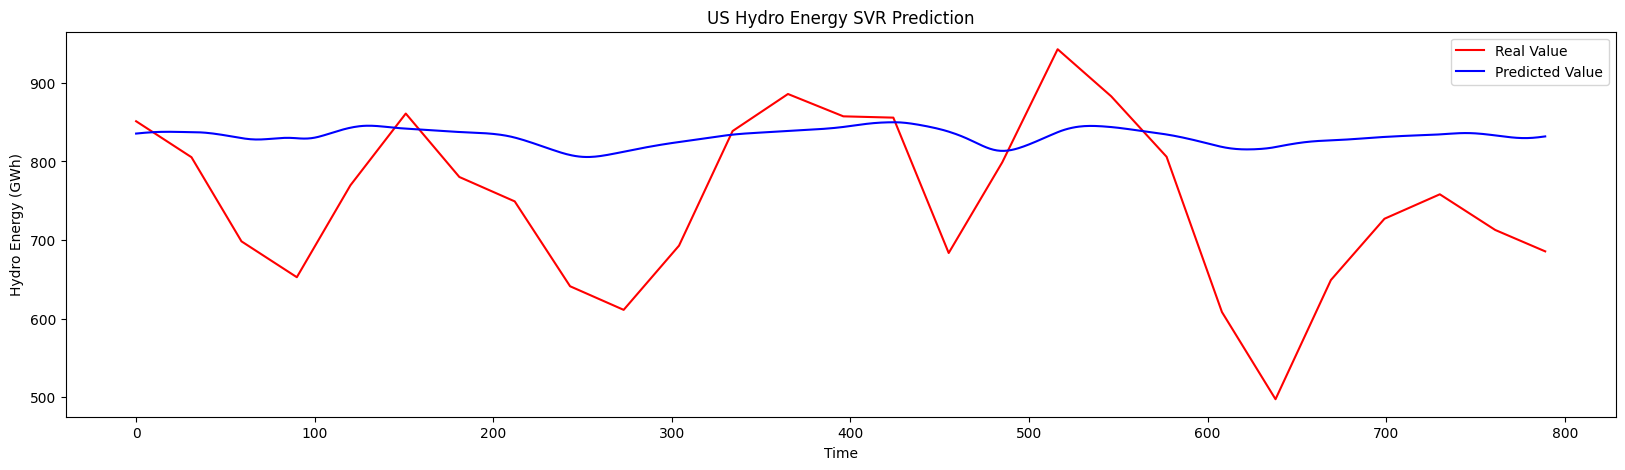

In [123]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('US Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate ANN - Daily

In [56]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

In [57]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test.values, time_steps)

X_train.shape

(3654, 365, 1)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create the model
us_daily_ann = Sequential()
us_daily_ann.add(Dense(84, activation='tanh', input_shape=(365,)))
us_daily_ann.add(Dropout(0.2))
us_daily_ann.add(Dense(1, activation='linear'))

us_daily_ann.compile(optimizer='adam', loss='mean_squared_error')

us_daily_ann.fit(X_train, y_train, epochs=100, batch_size=16)

Epoch 1/100
229/229 [==============================] - 1s 2ms/step - loss: 0.0936
Epoch 2/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 3/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0096
Epoch 4/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 5/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 6/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0059
Epoch 7/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 8/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0044
Epoch 9/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0038
Epoch 10/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0058
Epoch 11/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 12/100
229/229 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 13/100


In [124]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-365:i])
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

ann_y_pred = us_daily_ann.predict(X_test)
ann_y_pred = sc.inverse_transform(ann_y_pred)

25/25 [==============================] - 4s 23ms/step


In [125]:
print("Mean Absolute Error: ", mean_absolute_error(ann_y_pred, test.values))
mse = mean_squared_error(ann_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  6.702581031826094
Mean Squared Error:  70.34507655061556
Root Mean Squared Error:  8.387197180859381


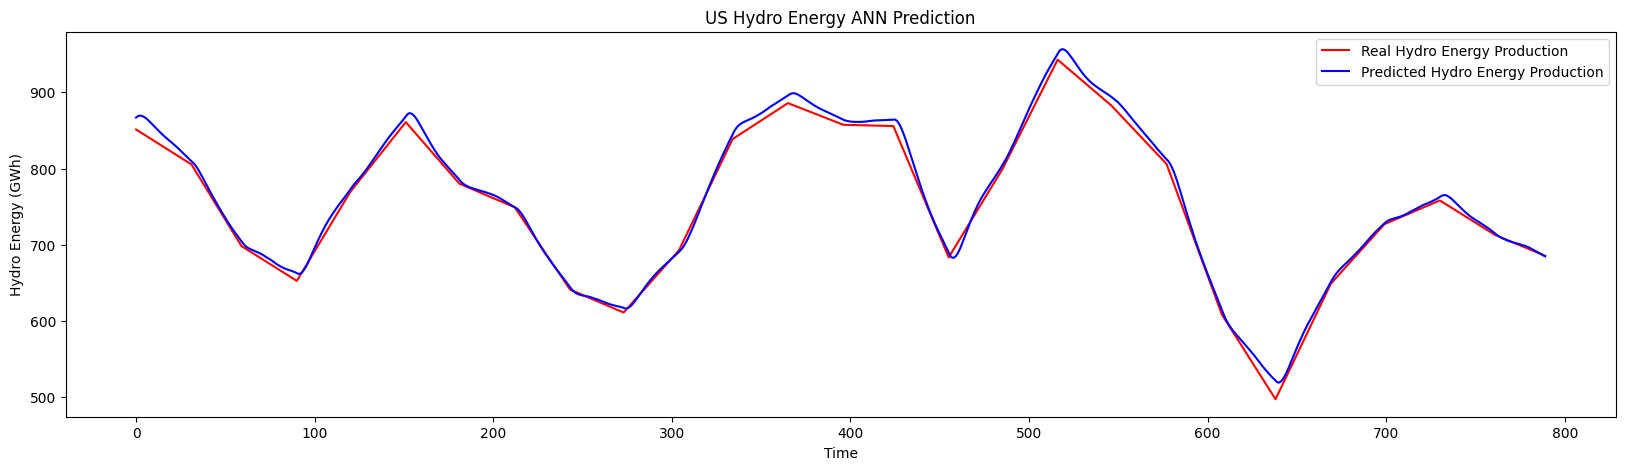

In [126]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(ann_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy ANN Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [62]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train.values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.37968131]
 [0.38077405]
 [0.38186678]
 ...
 [0.49261996]
 [0.49567437]
 [0.49872879]]
(4019, 1)


In [63]:
# Creating a data structure with 60 timestamps and 1 output
X_train = []
y_train = []
for i in range(365, len(train)):
    X_train.append(training_set_scaled[i-365:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [64]:
print(X_train)
X_train.shape

[[0.37968131 0.38077405 0.38186678 ... 0.55632536 0.56101479 0.56570423]
 [0.38077405 0.38186678 0.38295952 ... 0.56101479 0.56570423 0.57039367]
 [0.38186678 0.38295952 0.38405226 ... 0.56570423 0.57039367 0.5723053 ]
 ...
 [0.47359914 0.47584417 0.48051077 ... 0.48345671 0.48651113 0.48956554]
 [0.47584417 0.48051077 0.48517737 ... 0.48651113 0.48956554 0.49261996]
 [0.48051077 0.48517737 0.48984397 ... 0.48956554 0.49261996 0.49567437]]


(3654, 365)

In [65]:
print(y_train)
y_train.shape

[0.57039367 0.5723053  0.57421694 ... 0.49261996 0.49567437 0.49872879]


(3654,)

In [66]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [67]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [68]:
# Initialising the RNN
us_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
us_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
us_daily_uni_lstm.add(Dropout(0.2))

us_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
us_daily_uni_lstm.add(Dropout(0.2))

us_daily_uni_lstm.add(LSTM(units = 64))
us_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
us_daily_uni_lstm.add(Dense(units = 1))

In [69]:
# Compiling the RNN
us_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
us_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
115/115 [==============================] - 38s 281ms/step - loss: 0.0142
Epoch 2/100
115/115 [==============================] - 30s 263ms/step - loss: 0.0032
Epoch 3/100
115/115 [==============================] - 31s 266ms/step - loss: 0.0027
Epoch 4/100
115/115 [==============================] - 31s 266ms/step - loss: 0.0020
Epoch 5/100
115/115 [==============================] - 32s 278ms/step - loss: 0.0021
Epoch 6/100
115/115 [==============================] - 32s 281ms/step - loss: 0.0017
Epoch 7/100
115/115 [==============================] - 32s 281ms/step - loss: 0.0016
Epoch 8/100
115/115 [==============================] - 35s 302ms/step - loss: 0.0016
Epoch 9/100
115/115 [==============================] - 33s 287ms/step - loss: 0.0015
Epoch 10/100
115/115 [==============================] - 32s 277ms/step - loss: 0.0014
Epoch 11/100
115/115 [==============================] - 33s 284ms/step - loss: 0.0013
Epoch 12/100
115/115 [==============================] - 32s 275

Epoch 93/100
115/115 [==============================] - 34s 297ms/step - loss: 4.0602e-04
Epoch 94/100
115/115 [==============================] - 34s 291ms/step - loss: 3.6946e-04
Epoch 95/100
115/115 [==============================] - 35s 307ms/step - loss: 3.5745e-04
Epoch 96/100
115/115 [==============================] - 35s 304ms/step - loss: 3.7216e-04
Epoch 97/100
115/115 [==============================] - 34s 292ms/step - loss: 3.6279e-04
Epoch 98/100
115/115 [==============================] - 34s 294ms/step - loss: 3.8479e-04
Epoch 99/100
115/115 [==============================] - 34s 295ms/step - loss: 3.5081e-04
Epoch 100/100
115/115 [==============================] - 32s 278ms/step - loss: 3.8447e-04


In [70]:
test[['Value']].shape

(790, 1)

In [127]:

dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(365, len(test) + 365):
    X_test.append(inputs[i-365:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = us_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 26s 265ms/step


In [128]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test.values))
mse = mean_squared_error(uni_lstm_y_pred, test.values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.046821589888756
Mean Squared Error:  27.36239441487047
Root Mean Squared Error:  5.230907609093327


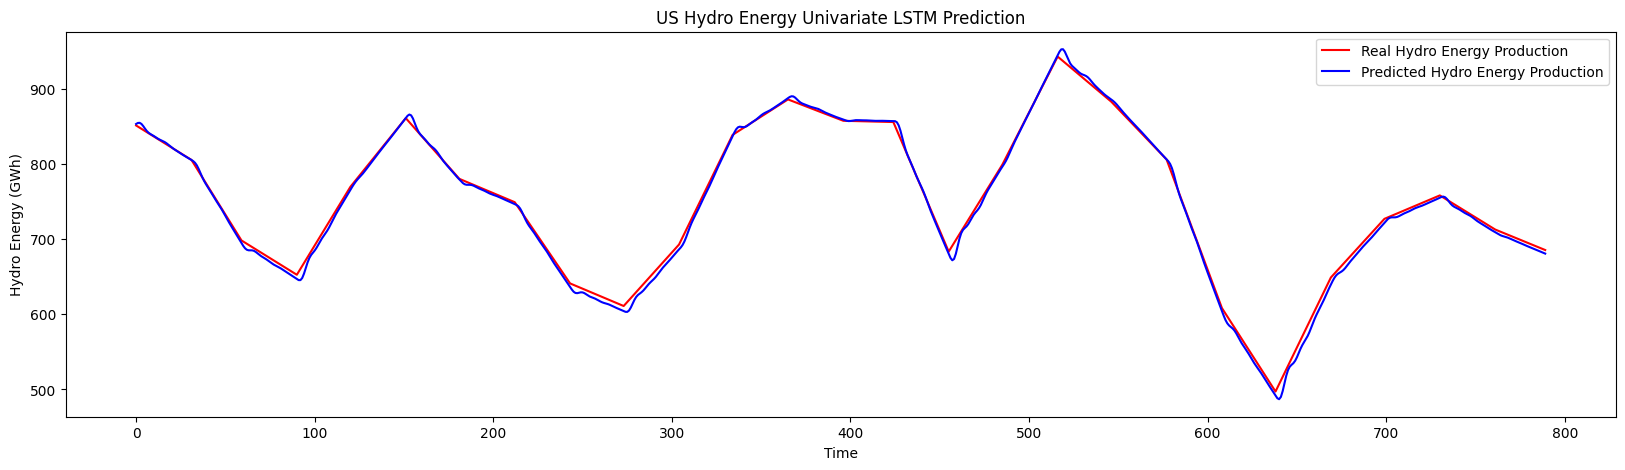

In [129]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test.values, color = 'red', label = 'Real Hydro Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Hydro Energy Production')
plt.title('US Hydro Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [74]:
data = hydro_production_data['United States']

data.shape

(4808, 2)

In [134]:
X = data[['Precipitation', 'Value']]
y = data[['Value']]

X.head()

,Precipitation,Value
Date,,
2010-01-01,0.090444,783.350323
2010-01-02,0.090238,783.972514
2010-01-03,0.090033,784.594705
2010-01-04,0.089827,785.216896
2010-01-05,0.089622,785.839087


In [135]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [136]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [78]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(4019, 2)
(790, 2)

(4019, 1)
(790, 1)


In [79]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

print(X_train1.shape)

(3654, 365, 2)


In [80]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

us_daily_multi_lstm = Sequential()
us_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(LSTM(units = 64))
us_daily_multi_lstm.add(Dropout(0.2))
us_daily_multi_lstm.add(Dense(1))

In [81]:
us_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

us_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
115/115 [==============================] - 38s 288ms/step - loss: 0.0136
Epoch 2/100
115/115 [==============================] - 33s 286ms/step - loss: 0.0034
Epoch 3/100
115/115 [==============================] - 35s 300ms/step - loss: 0.0026
Epoch 4/100
115/115 [==============================] - 35s 308ms/step - loss: 0.0022
Epoch 5/100
115/115 [==============================] - 37s 318ms/step - loss: 0.0021
Epoch 6/100
115/115 [==============================] - 36s 311ms/step - loss: 0.0020
Epoch 7/100
115/115 [==============================] - 38s 335ms/step - loss: 0.0018
Epoch 8/100
115/115 [==============================] - 39s 341ms/step - loss: 0.0018
Epoch 9/100
115/115 [==============================] - 38s 330ms/step - loss: 0.0015
Epoch 10/100
115/115 [==============================] - 35s 309ms/step - loss: 0.0015
Epoch 11/100
115/115 [==============================] - 36s 315ms/step - loss: 0.0013
Epoch 12/100
115/115 [==============================] - 36s 315

115/115 [==============================] - 84s 733ms/step - loss: 4.1640e-04
Epoch 94/100
115/115 [==============================] - 85s 735ms/step - loss: 3.9641e-04
Epoch 95/100
115/115 [==============================] - 87s 755ms/step - loss: 3.9964e-04
Epoch 96/100
115/115 [==============================] - 81s 705ms/step - loss: 3.7805e-04
Epoch 97/100
115/115 [==============================] - 77s 672ms/step - loss: 4.1734e-04
Epoch 98/100
115/115 [==============================] - 95s 828ms/step - loss: 3.7437e-04
Epoch 99/100
115/115 [==============================] - 97s 842ms/step - loss: 3.5741e-04
Epoch 100/100
115/115 [==============================] - 100s 872ms/step - loss: 3.5896e-04


In [137]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)

X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = us_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)

25/25 [==============================] - 8s 269ms/step


In [138]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  3.3646126407544603
Mean Squared Error:  40.90126714533402
Root Mean Squared Error:  6.395409849676096


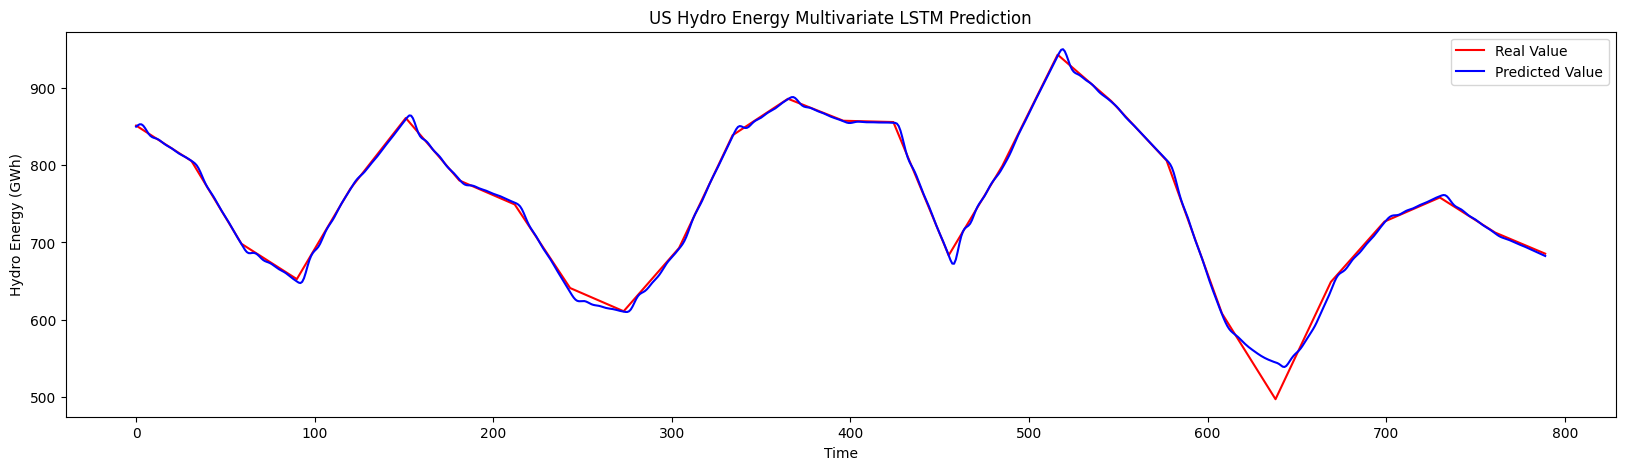

In [139]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('US Hydro Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Discussion:
Based on the finding above, it can show that the model train with daily data are out perform than using monthly data for all the models build.
Therefore, in the folling models build for other countries, the developer will use the daily data to build the time series models.

# Overview

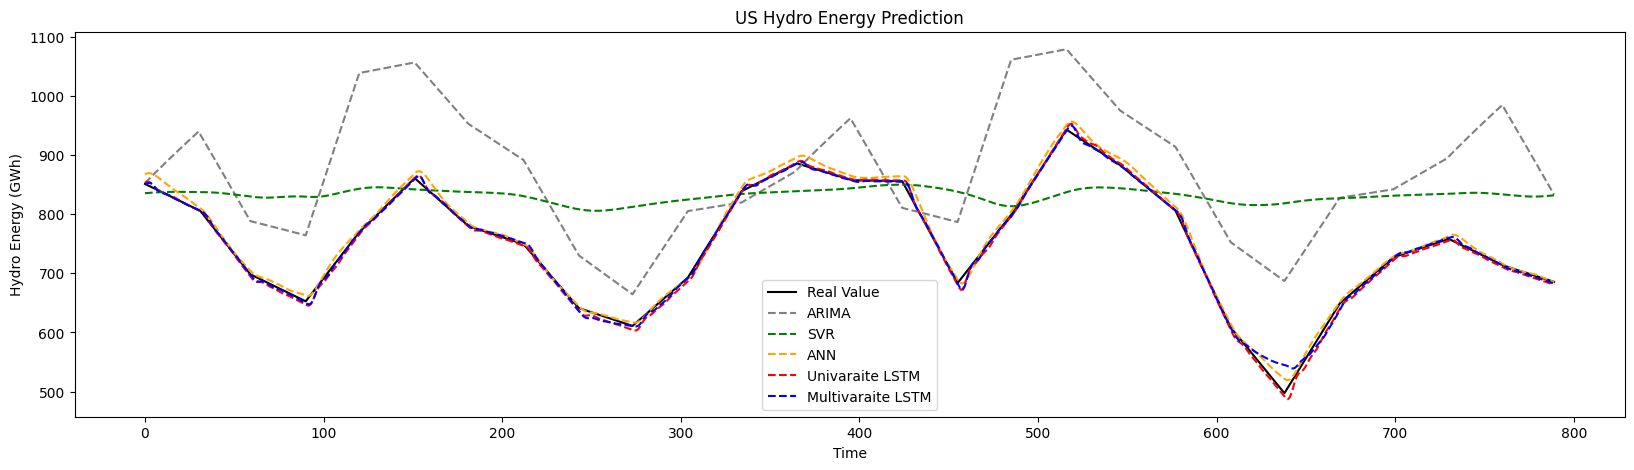

In [177]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(ann_y_pred, color='orange', linestyle='--', label='ANN')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('US Hydro Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Tuning

In [151]:
data = hydro_production_data['United States']

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date][['Value']], data[split_date:][['Value']]

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data to fit
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)


dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

(3654, 365) (3654,)


In [88]:
# SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

# Define the hyperparameter grid to search
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
}

# Use TimeSeriesSplit for time series data
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV with SVR model, hyperparameter grid, and TimeSeriesSplit
grid_search = GridSearchCV(estimator=us_daily_svr, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=1)

# Perform the grid search to find the best hyperparameters
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(C=10, epsilon=0.05, gamma=0.5),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=1)

In [89]:
# Get the best hyperparameters and best model
svr_best_params = grid_search.best_params_
svr_best_model = grid_search.best_estimator_

print(svr_best_params)
print(svr_best_model)

{'C': 10, 'epsilon': 0.01, 'kernel': 'linear'}
SVR(C=10, epsilon=0.01, gamma=0.5, kernel='linear')


In [156]:
# Train the best model on the full training set
svr_best_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = svr_best_model.predict(x_test).reshape(-1,1)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(y_pred, test['Value'].values))
mse = mean_squared_error(y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  2.9209207851629837
Mean Squared Error:  13.295255228401702
Root Mean Squared Error:  3.6462659294683517


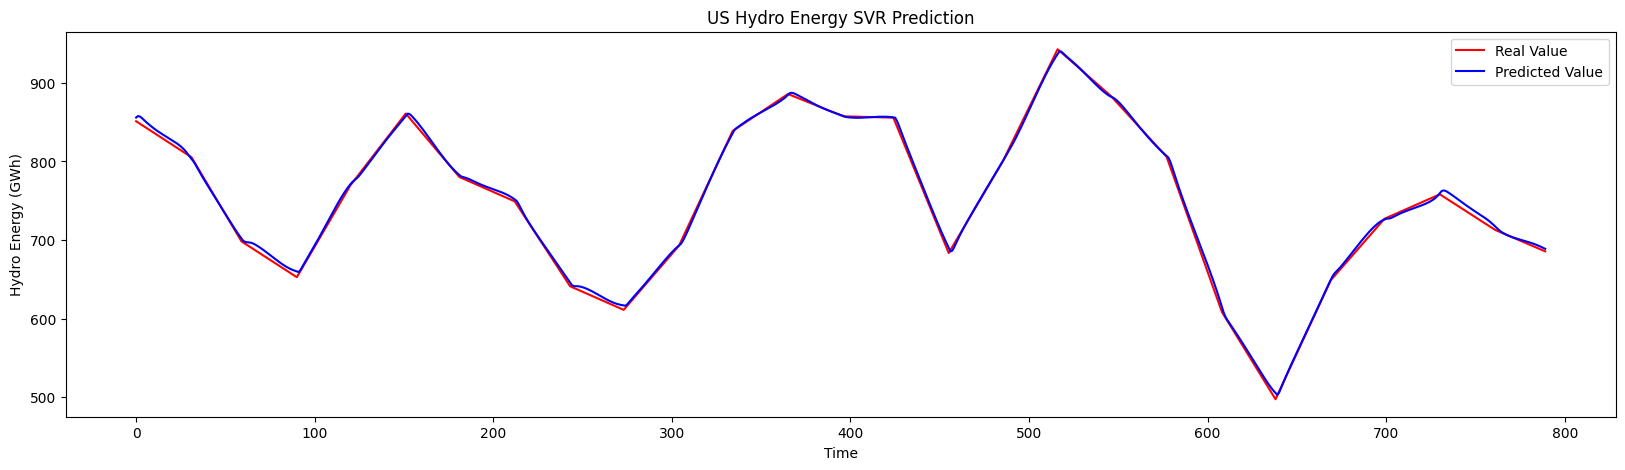

In [157]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(y_pred, color='blue', label='Predicted Value')
plt.title('US Hydro Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Hydro Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [108]:
us_daily_uni_lstm.save('us_hydro_best_uni_lstm.h5')

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
import joblib

# Save the SVR model to a file
joblib.dump(svr_best_model, "us_hydro_svr_best_model.pkl")

['us_hydro_svr_best_model.pkl']